# 1. 라이브러리 불러오기

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

# 2. 데이터 불러오기 및 전처리

In [183]:
# 데이터 불러오기
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
IDtest = test['PassengerId']

In [184]:
# Outlier Detection
def detect_outliers(df, n, features):
    """
    Tukey Method를 활용하여 n개 이상의 Outlier를 가진 관측치를 리스트의 형식으로 추출하기
    """
    outlier_indices = []
    
    # 특성별로 시행하기
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Feature 당 아웃라이어 정의하기
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index 
        
        # 추출한 아웃라이어 인덱스를 리스트 형태로 추출
        outlier_indices.extend(outlier_list_col)
        
    # 2개이상의 outlier를 포함하는 관측값들 추출
    outlier_indices = Counter(outlier_indices) # Counter('hello world') => Counter({'l': 3, 'o': 2, 'h': 1, 'e': 1, ' ': 1, 'w': 1, 'r': 1, 'd': 1})
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n) # n개 이상의 아웃라이어 추출
    
    return multiple_outliers

# Age, SibSp, Parch and Fare의 Outlier 추출
Outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])
Outliers_to_drop

[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]

In [185]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [186]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop = True)

In [187]:
# 훈련용과 테스트용 합치기
train_len = len(train)
dataset = pd.concat(objs = [train, test], axis = 0).reset_index(drop = True)

In [188]:
# 결측치 처리
## 모든 결측치 NaN으로 채우기
dataset = dataset.fillna(np.nan)

## 결측치확인
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [189]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

# 3. Feature analysis

## 3.1 숫자형데이터

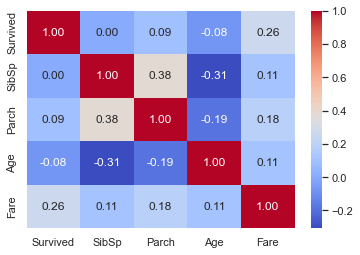

In [190]:
# 숫자형 데이터
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age','Fare']].corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')

"Survived"와 연관성이 있어보이는 특성은 'Fare' 하나만 보이지만 조금 더 파고들어갈 필요가 있어보인다.

## SibSp

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


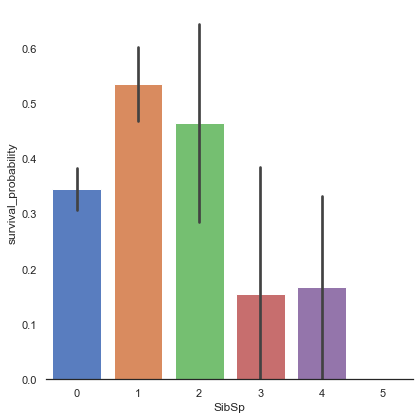

In [191]:
# SibSp
g = sns.factorplot('SibSp', 'Survived', data = train, kind = 'bar', size = 6, palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('survival_probability')

가족규모가 1~2인경우는 살아남은 사람이 많았지만 그이상의 가족규모를 가진 사람은 상대적으로 살아남기 힘들었다

## Parch

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


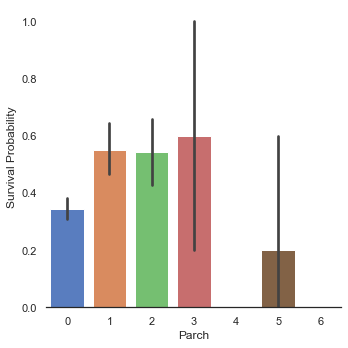

In [192]:
# Parch
g = sns.factorplot('Parch', 'Survived', data= train, kind = 'bar', palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('Survival Probability')

## Age

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


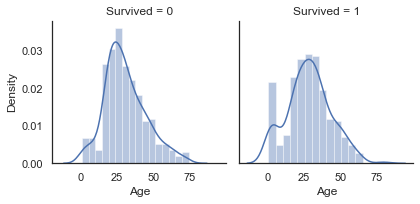

In [193]:
# Age
g = sns.FacetGrid(train, col = 'Survived')
g = g.map(sns.distplot, 'Age')

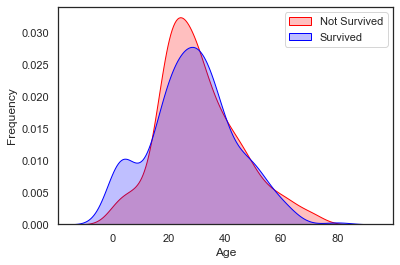

In [194]:
# Age에 대해서 더 알아보기
g = sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color = 'Red', shade = True)
g = sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Age'].notnull())], color = 'Blue', ax = g, shade = True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

나이가 어릴수록 생존률이 높은것을 확인


## Fare

In [195]:
# Fare
dataset['Fare'].isnull().sum()

1

In [196]:
# 결측치가 적으므로 medina()으로 대체
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


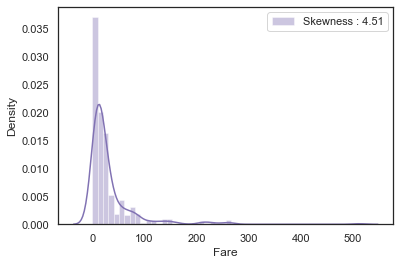

In [197]:
# Fare 분포도 알아보기
g = sns.distplot(dataset['Fare'], color = 'm', label = 'Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc = 'best')

왼쪽으로 치우쳐져있는 형태를 띄고 있다. --> 로그변환 실행

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


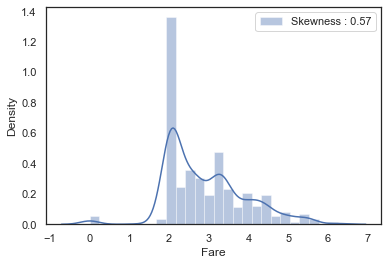

In [198]:
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
g = sns.distplot(dataset['Fare'], color = 'b', label = 'Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc = 'best')

## 3.2 범주형데이터

## Sex

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


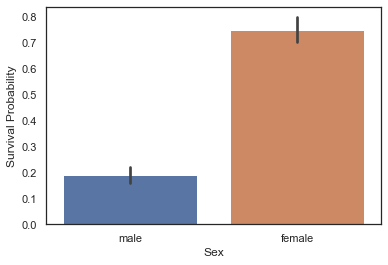

In [199]:
g = sns.barplot('Sex', 'Survived', data=train)
g = g.set_ylabel('Survival Probability')

In [200]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


여성이 남성보다 생존율이 월등히 높다

## Pclass


/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


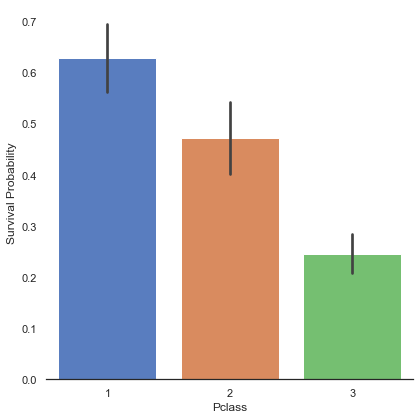

In [201]:
# Pclass vs Survived
g = sns.factorplot('Pclass', 'Survived', data=train, kind = 'bar', size = 6, palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('Survival Probability')

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


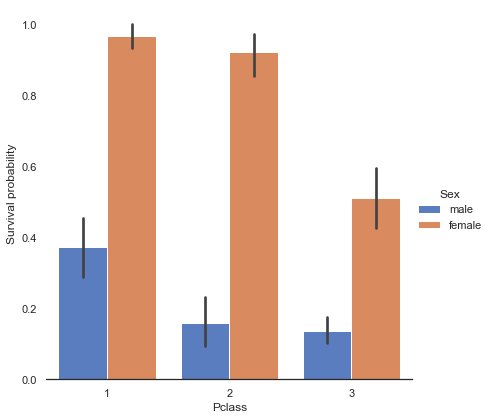

In [202]:
# Pclass vs Survived by Sex
g = sns.factorplot('Pclass', 'Survived', hue = 'Sex', data=train, kind = 'bar', size = 6, palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('Survival probability')

클래스가 높은 좌석일수록 생존률이 전체적으로 높았으며 여성이 남성보다 월등히 생존률이 높다

## Embarked

In [203]:
dataset['Embarked'].isnull().sum()

2

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


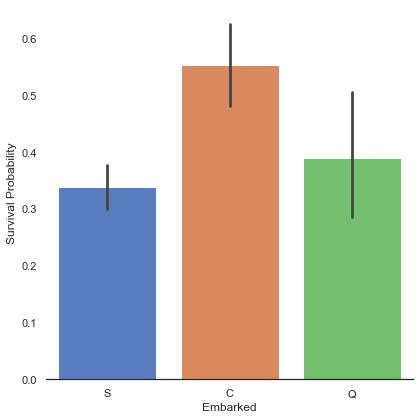

In [204]:
# 2개의 결측치는 가장 빈번한 데이터로 변환
dataset['Embarked'] = dataset['Embarked'].fillna('S')

# Embarked vs Survived
g =sns.factorplot('Embarked', 'Survived', data= train, kind = 'bar', size = 6, palette = 'muted')
g.despine(left =True)
g=g.set_ylabels('Survival Probability')

C항구에서 탄 탑승객들의 생존율이 높았다.

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


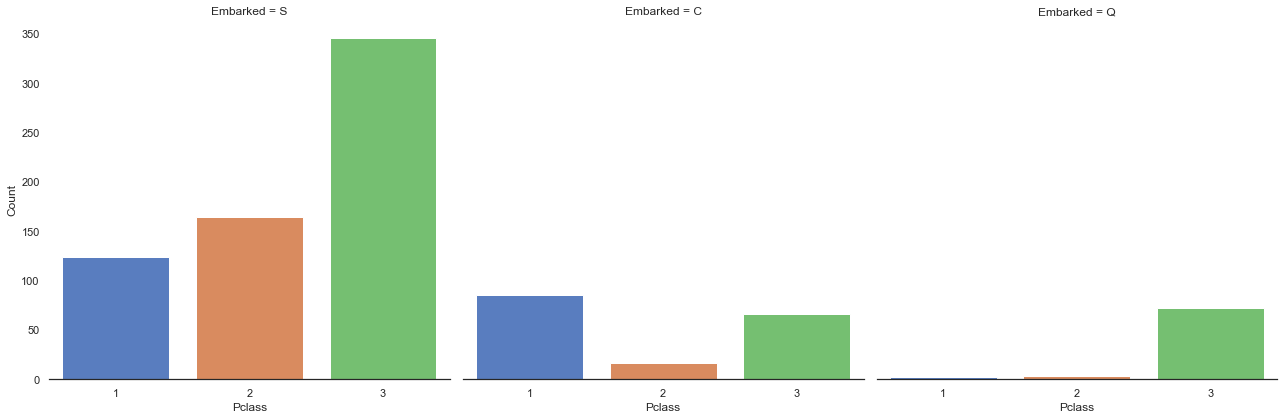

In [205]:
# Pclass vs Embarked
g = sns.factorplot('Pclass', col = 'Embarked', data= train, size = 6, kind = 'count', palette = 'muted')
g.despine(left = True)
g=g.set_ylabels('Count')

S항구가 가장 많은 탑승객들이 이용한 항구이지만 생존율이 낮은 것은 클래스가 3인 탑승객의 생존율 때문인것으로 보인다. 

반면에, C의 생존율이 높은 이유는 C항구의 1st 클래스 탑승객의 생존율이 높아서 생긴 현상인 듯 하다.

# 4. 결측치처리

## 4. 1Age

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the

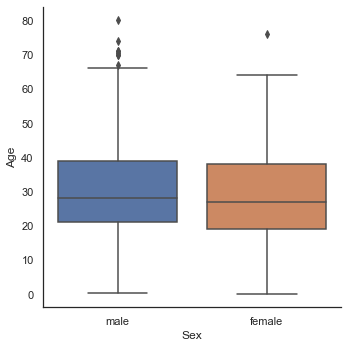

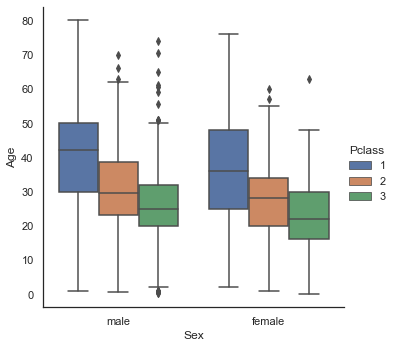

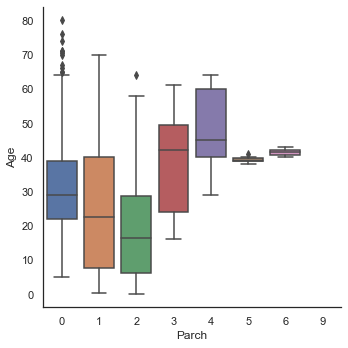

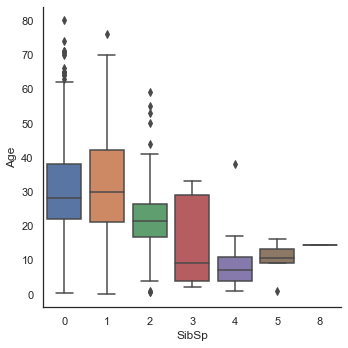

In [206]:
# Age vs Sex, Parch, Plcass and SibSp
g=sns.factorplot(y='Age',x = 'Sex', data= dataset, kind = 'box')
g=sns.factorplot(y='Age', x='Sex', hue = 'Pclass', data=dataset, kind = 'box')
g = sns.factorplot(y = 'Age', x = 'Parch', data=dataset, kind = 'box')
g = sns.factorplot(y = 'Age', x = 'SibSp', data= dataset, kind = 'box')

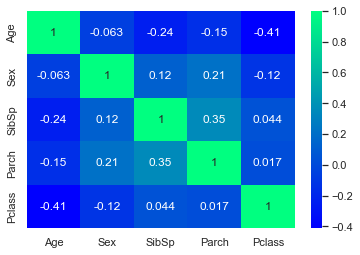

In [207]:
# Sex를 숫자형으로 전환
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})
g = sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), annot = True, cmap = 'winter')



In [208]:
# Age 결측치처리 
# 결측치를 가지고 있는 인덱스 추출
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][((dataset['SibSp'] == dataset.iloc[i]['SibSp']) &
                               (dataset['Parch'] == dataset.iloc[i]['Parch']) &
                               (dataset['Pclass'] == dataset.iloc[i]['Pclass']))].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


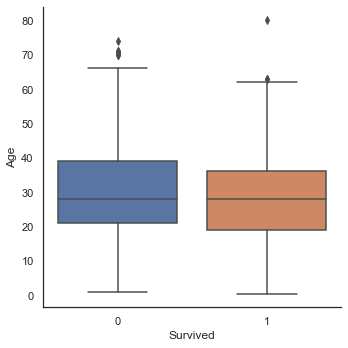

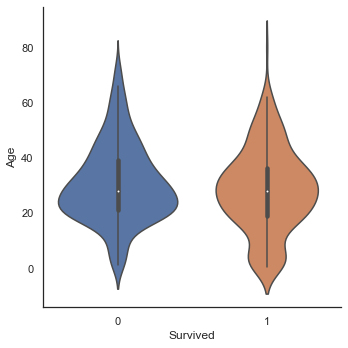

In [209]:
g = sns.factorplot(x = 'Survived', y = 'Age', data=train, kind = 'box')
g = sns.factorplot(x = 'Survived', y = 'Age', data= train, kind = 'violin')

# 5. Feature Engineering
## 5.1 Name/Title

In [210]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [211]:
# title 추출하기
dataset_title = dataset['Name'].str.extract('([A-Za-z]+)\.')
dataset['Title'] = dataset_title
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

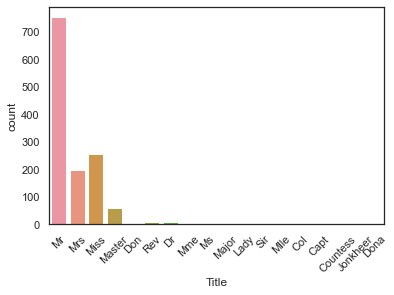

In [212]:
g = sns.countplot(x = 'Title', data=dataset)
g = plt.setp(g.get_xticklabels(),rotation=45)

In [213]:
# Title 수정하기
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


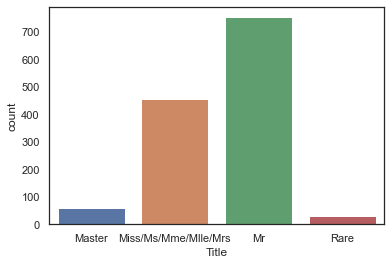

In [214]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(['Master','Miss/Ms/Mme/Mlle/Mrs', 'Mr','Rare'])

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


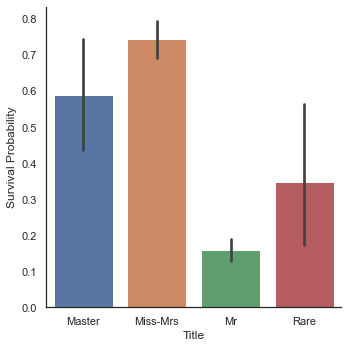

In [215]:
g = sns.factorplot(x='Title',y = 'Survived',data=dataset, kind = 'bar')
g = g.set_xticklabels(['Master','Miss-Mrs','Mr','Rare'])
g = g.set_ylabels('Survival Probability')

"여자와 어린아이 우선구조"

Rare의 타이틀을 가진 사람의 생존율이 높은것이 흥미롭다

In [216]:
# 이름 제거
dataset.drop(labels =['Name'], axis = 1, inplace = True)

## 5.2 Family Size

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


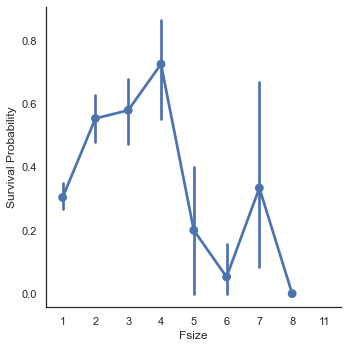

In [217]:
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

g=sns.factorplot(x = 'Fsize', y = 'Survived', data= dataset)
g = g.set_ylabels('Survival Probability')

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the

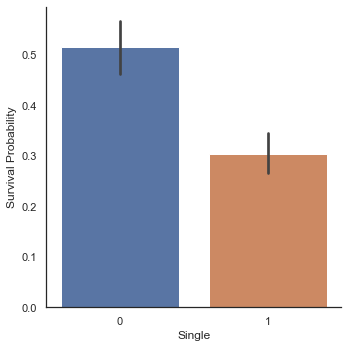

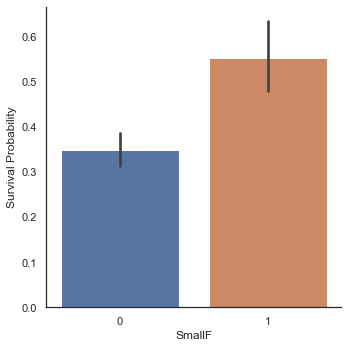

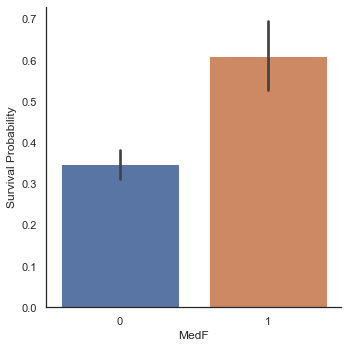

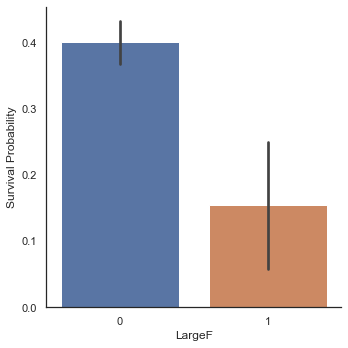

In [218]:
# 가족규모와 관련된 새로운 Feature 만들기
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >4 else 0)

g = sns.factorplot(x = 'Single', y = 'Survived', data= dataset, kind = 'bar')
g = g.set_ylabels('Survival Probability')
g = sns.factorplot(x = 'SmallF', y = 'Survived', data= dataset, kind = 'bar')
g = g.set_ylabels('Survival Probability')
g = sns.factorplot(x = 'MedF', y = 'Survived', data= dataset, kind = 'bar')
g = g.set_ylabels('Survival Probability')
g = sns.factorplot(x = 'LargeF', y = 'Survived', data= dataset, kind = 'bar')
g = g.set_ylabels('Survival Probability')


In [219]:
# Title과 Embarked one-hot encoding
dataset = pd.get_dummies(dataset, columns = ['Title'])
dataset = pd.get_dummies(dataset, columns = ['Embarked'], prefix = 'Em')
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


## 5.3 Cabin

In [220]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [221]:
dataset['Cabin'].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [222]:
dataset['Cabin'].isnull().sum()

1007

In [223]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [224]:
# 결측치는 'X'로 대체
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])
dataset['Cabin'].value_counts()

X    1007
C      91
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin, dtype: int64

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


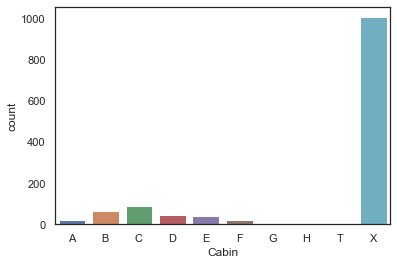

In [225]:
g = sns.countplot(dataset['Cabin'], order = ['A','B','C','D','E','F','G','H','T','X'])

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


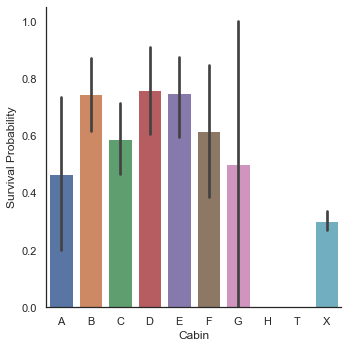

In [226]:
g = sns.factorplot(y = 'Survived', x = 'Cabin', data= dataset, kind = 'bar',
                   order = ['A','B','C','D','E','F','G','H','T','X'] )
g = g.set_ylabels('Survival Probability')

낮은 등급의 승객은 개인서랍이 없을 가능성이 크기에 생존율이 낮은 형태로 나타난다. 하지만 Cabin간의 생존율 차이를 정확하게 구별할 수는 없다.

하지만 B, C, D, E, F는 월등히 생존율이 높다.

In [227]:
# 인코딩
dataset=pd.get_dummies(dataset, columns = ['Cabin'], prefix = 'Cabin')

## 5.4 Ticket

In [228]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [229]:
## 티켓의 앞글자만 추출하고 없을경우 'X'로 대체

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [230]:
dataset = pd.get_dummies(dataset, columns = ['Ticket'], prefix = 'T')

# Pclass 인코딩
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Pclass'], prefix = 'Pc')

# 불필요한 컬럼 제거
dataset.drop(labels = ['PassengerId'], axis = 1, inplace = True)
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


# 6. 모델링

In [233]:
# 데이터셋 나누기
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels = ['Survived'], axis = 1, inplace = True)

# 훈련용데이터 세분화
train['Survived'] = train['Survived'].astype(int)
Y_train = train['Survived']
X_train = train.drop(labels = ['Survived'], axis = 1)

/var/folders/4s/mdcm3tk115gg487lsv_xvr_w0000gn/T/ipykernel_1685/3549240826.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Survived'] = train['Survived'].astype(int)


## 6.1 Simple modeling

### 6.1.1 Cross Validate Models

- SVC
- Decision Tree
- AdaBoost
- RandomForest
- Extra Trees
- Gradient Boosting
- Multiple Layer perceptron (Neural network)
- KNN
- Logistic Regression
- Linear Discriminal Analysis

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature na

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


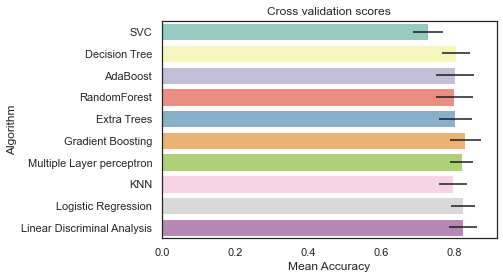

In [239]:
kfold = StratifiedKFold(n_splits = 10)

# modeling
random_state = 2
classifiers = []
classifiers.append(SVC(random_state = random_state))
classifiers.append(DecisionTreeClassifier(random_state = random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state = random_state),
                                      random_state=random_state,
                                      learning_rate = 0.1))
classifiers.append(RandomForestClassifier(random_state = random_state))
classifiers.append(ExtraTreesClassifier(random_state = random_state))
classifiers.append(GradientBoostingClassifier(random_state = random_state))
classifiers.append(MLPClassifier(random_state = random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

# 결과취합
cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train,Y_train, cv = kfold, scoring='accuracy', n_jobs = 4))

# 결과 평균과 표준편차
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({'CrossValMeans': cv_means, 'CrossValerrors': cv_std,
                       'Algorithm': ['SVC','Decision Tree', 'AdaBoost', 'RandomForest', 
                                     'Extra Trees', 'Gradient Boosting','Multiple Layer perceptron',
                                     'KNN','Logistic Regression', 'Linear Discriminal Analysis']})

g = sns.barplot('CrossValMeans','Algorithm', data= cv_res, palette = 'Set3', orient = 'h', **{'xerr': cv_std})
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross validation scores')

### 6.1.2 하이퍼파라미터튜닝 


In [241]:
### Meta Modeling with AdaBoost, RF, Extra Tress and Gradient Boosting

# Adaboost
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state = 7)
ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature na

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature na

  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature na

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature na

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature na

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature na

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature na

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature na

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature na

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature na

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature na

In [242]:
gsadaDTC.best_score_

0.8275536261491316

In [243]:
# Extra Tress

ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8297497446373852

In [244]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8331460674157304

In [245]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_


Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8331460674157304

In [246]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8331332992849847

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature na

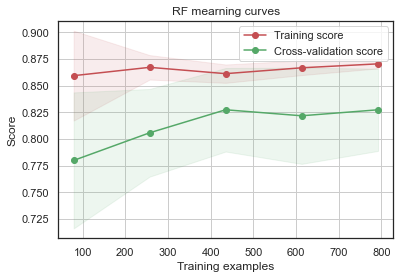

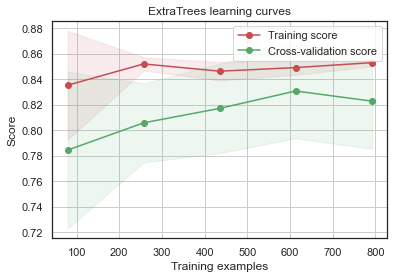

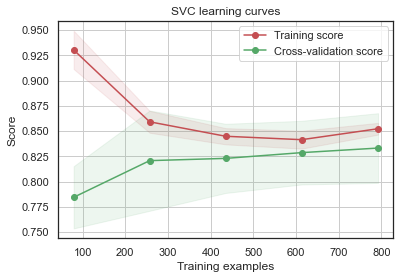

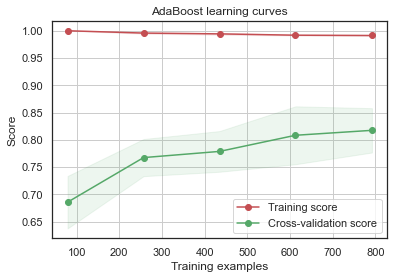

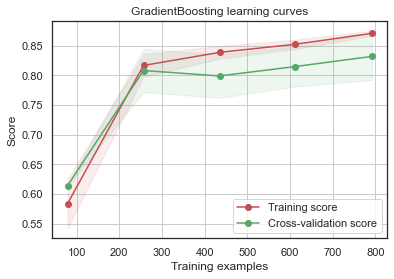

In [247]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim) # 많은 다양한 수를 넣을 수 있도록 *arg를 넣어줌
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    # fill_between() 메소드를 활용하여 표준편차에 따른 범위 시각화 가능
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r") 
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # Cross Validation을 통해 얻은 score의 평균값 시각화
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

SVC와 ExtraTree가 상대적으로 일반화가 잘되어 있다.

Adaboost와 Gradient Boosting은 과적합하려는 경향을 보인다.

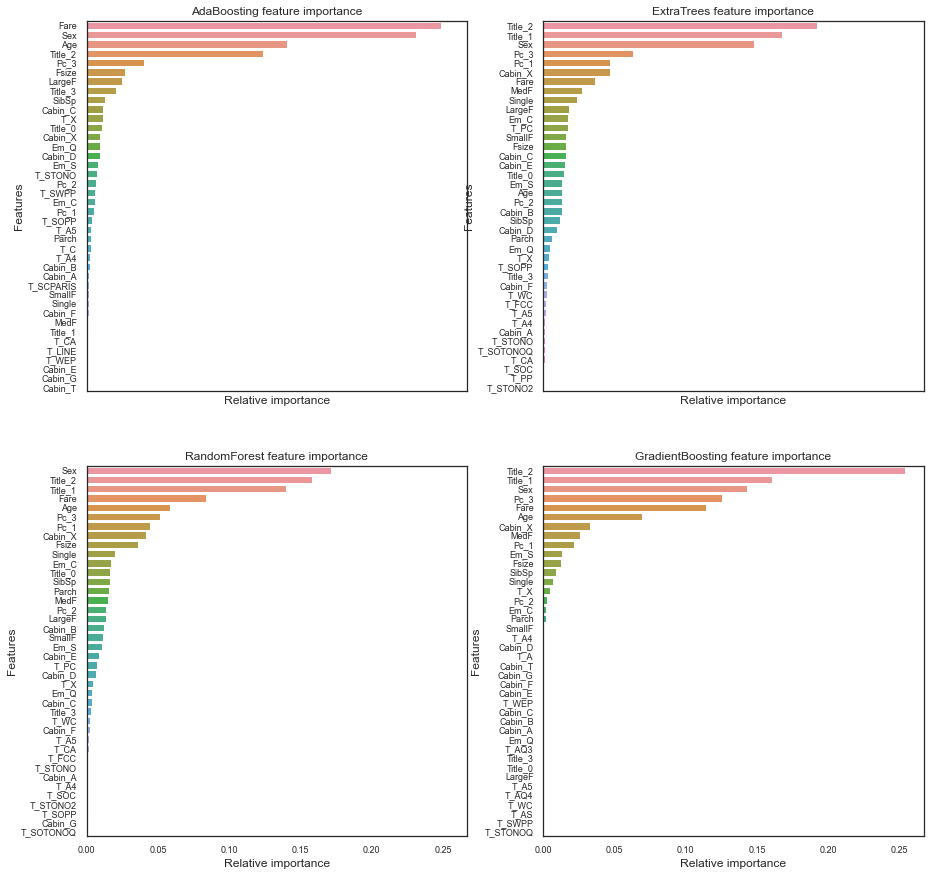

In [248]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        # 분류모델 이름과 best모델 지정
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        
        # 중요도 추출 및 정열
        indices = np.argsort(classifier.feature_importances_)[::-1][:40] # 40번째 컬럼까지만
        
        # 시각화
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

4가지 다른 알고리즘에서 상위권에 해당하는 컬럼이 제각각이지만 공통된 컬럼이 존재한다.

'Fare','Title_2','Age','Sex'이다.

이를 토대로 나이, 성별, 가족규모가 모델에 크게 영향을 준다는 것을 알아낼 수 있다.

/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


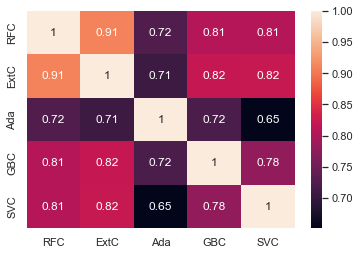

In [249]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

## 6.2 Ensemble Modeling

### 6.2.1 Combining models for Voting

In [253]:
votingC = VotingClassifier(estimators = [('rfc', RFC_best), ('extc', ExtC_best), ('svc', SVMC_best),
                                         ('adac',ada_best), ('gbc',GBC_best)], voting = 'soft',n_jobs = 4)

votingC = votingC.fit(X_train, Y_train)

# prediction
test_Survived = pd.Series(votingC.predict(test), name = 'Survived')
results = pd.concat([IDtest, test_Survived], axis = 1)



/Users/xper100/opt/anaconda3/envs/kagglestudy/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


In [254]:
results.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
